# Bayesian Hierarchical Clustering
## Prototype Build

The intent of this notebook is to implement a preliminary version of the *Bayesian Hierarchical Clustering* (BHC) algorithm.

*Sources:*

- https://cs.fit.edu/~dmitra/ArtInt/Spring2017/Projects/DM-on_ReportBayesian_Clustering_Project_Report_nlowing_rbomalaski.pdf

In [1]:
import numpy as np
import scipy as sc
import pandas as pd
import seaborn as sns
import itertools as it
from scipy import stats
from scipy import linalg as la
from scipy import random as rnd
import matplotlib.pyplot as plt

### Generate Example Data

Example data will consist of a mixture of three gaussian distributions with varying parameters. It will be clustered via random draws of a multinomial distribution.

In [2]:
# bivariate gaussian params
mu1 = np.zeros(2)
cov1 = np.eye(2)

mu2 = np.array([5, 3])
cov2 = np.eye(2) * 2

mu3 = np.array([8, 12])
cov3 = np.array([3.4, 0, 0, 5.1]).reshape(2, 2)

# multinom params
p1 = 0.2
p2 = 0
p3 = 1 - p2 - p1

# number of total draws
draws = 60

In [3]:
# random draws
rnd.seed(1)

knum = rnd.multinomial(draws, (p1, p2, p3))

gaus1 = rnd.multivariate_normal(mu1, cov1, knum[0])
gaus2 = rnd.multivariate_normal(mu2, cov2, knum[1])
gaus3 = rnd.multivariate_normal(mu3, cov3, knum[2])

In [4]:
# join columns into dataframe
x1 = pd.Series(np.r_[gaus1[:, 0], gaus2[:, 0], gaus3[:, 0]])
x2 = pd.Series(np.r_[gaus1[:, 1], gaus2[:, 1], gaus3[:, 1]])
c = pd.Series(np.r_[np.zeros(knum[0]), np.ones(knum[1]), np.ones(knum[2]) * 2])
dat = {"x1" : x1, "x2" : x2, "c" : c}
clustData = pd.DataFrame(dat)

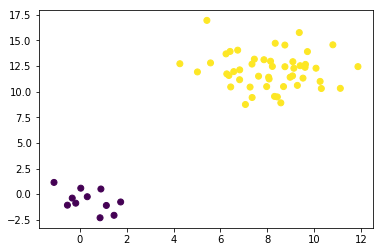

In [5]:
plt.scatter(clustData["x1"], clustData["x2"], c = clustData["c"])
plt.show()

### Preliminary Algorithm

***BHC Steps:***


1. Input
    - Data: $D = \{\vec{x_1}, ..., \vec{x_n}\}$ 
    - Select generative model: $p(\vec{x} | \theta)$
    - Select appropriate prior: $p(\theta | \theta_0)$

2. Initialize Stage
    - Number of initial clusters: `c = len(D)`
    - $D_i = {\vec{x_i}}$ for $i = 1, ..., n$

3. Iterate Stage
    `while c > 1:`
    
    - find data pair $D_i$, $D_j$ w/ highest posterior probability for merge hypothesis: $r_k = p(H^1_k | D_k) = \frac{p(D_k | H^1_k)\pi_k}{p(D_k | T_k)}$
    - merge clusters $D_k = D_i \cup D_j$
    - delete old clusters $D_i$ and $D_j$
    - interate number of clusters `c -= 1`
    
   `end loop`

***Output:***

Bayesian mixture model where each tree node is a mixture component. Tree can be cut at points where $r_k < 0.5$.

# Building Algorithm Components

### Defining the `Split` and `Leaf` Classes

The `Split` class will store all the information about a given split including the vectors that belong to that tree and subtrees.

The `Leaf` class stores fundamental information at the bottom tier.

In [6]:
class Leaf:
    """Leaf class contains information for each data point at tier 1 level"""
    
    def __init__(self, pt, alpha):
        """initialize Leaf object
        pt is an individual data point stored as a len 1 np array
        alpha is prior parameter for number of clusters"""
        self.tier = 1 # leaves start at tier 1
        self.alpha = alpha # prior on number of clusters
        self.tree = np.array([pt]) # leaves are single point trees (structured)
        self.clust = np.array([pt]) # leaves are single point clusters (unstructured group)
        self.clustsize = 1 # leaves have cluster size 1
        self.d = alpha # initial d_i
        self.pi = 1 # initial 

In [7]:
class Split:
    """Split class stores all information about a given split"""
    
    def __init__(self, clusti, clustj):
        """initialize Split object
        objDiTi - is a Split or Leaf object from cluster i (left split)
        objDjTj - is a Split or Leaf object from cluster j (right split)
        alpha is prior parameter for number of clusters"""
        self.left = clusti
        self.right = clustj
        self.alpha = clusti.alpha # alpha parameter will remain unchanged for tree (prior)
        self.tier = clusti.tier + clustj.tier
        self.clustsize = clusti.clustsize + clustj.clustsize
        self.tree = np.array([clusti.tree, clustj.tree])
        self.clust = np.hstack([clusti.clust, clustj.clust])
        
        # calculate new small d_k
        self.d = self.alpha * sc.special.gamma(self.clustsize) + clusti.d * clustj.d
        
        # calculate new pi_k
        self.pi = self.alpha * sc.special.gamma(self.clustsize) / self.d

#### Example Use of `Leaf ` and `Split`:

In [8]:
x = x1.values[0]
y = x2.values[0]
z = x2.values[1]

In [9]:
lx = Leaf(x, 2)
ly = Leaf(y, 2)
lz = Leaf(z, 2)

In [11]:
syx = Split(lx, ly)
syxz = Split(syx, lz)

In [20]:
### Hyper-Parameter Helper Functions ###

def wishart_hyperparams(dvec, **priorhps):
    """calculate posterior hyper-parameters for wishart distribution
    dvec - vector of observed data for likelihood distribution as np array
    **priorhps - kwargs as dictionary of prior hyperparameters
    hyperparameters must be k0 (1 x 1) and 
    precisionMatrix (n x n) where n is dvec.size"""
    n = dvec.size
    xbar = dvec.mean()
    
    kn = priorhps["k0"] + n # posterior degrees of freedom
    
    #C = 
    
    pass
    
    

In [12]:
# model parameters

### parameter notes ###
# Gaussian Distribution - loc is mean; scale is sd
# Gamma Distribution - a is shape; scale is rate; leave loc at 0

allParams = {
    "clusterConcentrationParam" : {"alpha" : 10},
    "diffusePriorGamma" : {"a" : 1/2, "loc" : 0, "scale" : 1/2}, # param / 2 for conj
    "diffusePriorNorm" : {"loc" : 0, "scale" : 1}, # normal params
}

In [22]:
gamma_normal_posterior_hps(np.array([1, 2, 3]), 5, **allParams["diffusePriorGamma"])

(4, 29)

### Evaluating Marginal Likelihood

In order to evaluate the marginal likelihood, we need to evaluate the below integral:

\begin{align}
p(D_k|H_k) &= \int_\theta p(D_k | \theta) p(\theta | \theta_0) d\theta \\
&= \int_\mu \int_\phi \prod_{i = 1}^n \mathcal{N}(x_i | \mu, \phi) \mathcal{G}(\phi | \alpha, \beta) \mathcal{N}(\mu | \mu_0, \tau^2) \thinspace d\phi \thinspace d\mu \\
&= \int_\mu \int_\phi \prod_{i = 1}^n \frac{\phi^{\frac{1}{2}}}{ \sqrt{2 \pi} } \exp \left({\frac{\phi(x_i - \mu)^2}{-2}} \right)
\frac{\beta^\alpha}{\Gamma(\alpha)}{\phi^{\alpha - 1} } e^{ - \beta \phi}
\frac{\tau^{\frac{1}{2}}}{ \sqrt{2 \pi} } \exp \left({\frac{\tau(\mu - \mu_0)^2}{-2}} \right)
\thinspace d\phi \thinspace d\mu \\
&= \int_\mu \left[ \int_\phi \prod_{i = 1}^n \frac{\phi^{\frac{1}{2}}}{ \sqrt{2 \pi} } \exp \left({\frac{\phi(x_i - \mu)^2}{-2}} \right)
\frac{\beta^\alpha}{\Gamma(\alpha)}{\phi^{\alpha - 1} } e^{ - \beta \phi} \thinspace d\phi \thinspace \right]
\frac{\tau^{\frac{1}{2}}}{ \sqrt{2 \pi} } \exp \left({\frac{\tau(\mu - \mu_0)^2}{-2}} \right)
\thinspace \thinspace d\mu \\
\end{align}


### Importance Sampler

$$
I = \int{h(x)\,p(x) \, dx}
$$

where $h(x)$ is some function and $p(x)$ is the PDF of $y$. If it is hard to sample directly from $p$, we can introduce a new density function $q(x)$ that is easy to sample from, and write

$$
I = \int{h(x)\, p(x)\, dx} = \int{h(x)\, \frac{p(x)}{q(x)} \, q(x) \, dx}
$$

In other words, we sample from $h(y)$ where $y \sim q$ and weight it by the likelihood ratio $\frac{p(y)}{q(y)}$, estimating the integral as

$$
\frac{1}{n}\sum_{i=1}^n \frac{p(y_i)}{q(y_i)} h(y_i)
$$



In [1]:
### helper functions for normal-gamma importance sampler ###

def gamma_normal_posterior_hps(dvec, muuk, **priorhps):
    """calculate posterior hyper-parameters for gamma distribution
    This is gamma-normal conjugate posterior w/ precision parameterization
    dvec - vector of observed data for likelihood distribution as np array
    muuk - unknown value for generative distribution mean (H1)
    **priorhps - kwargs as dictionary of prior hyperparameters
    hyperparameters must be:
    Normal ("priorMeanParams"):
    loc - mean
    scale - standard deviation
    Gamma ("priorPrecisParams"):
    a - shape
    loc - location (for most purpose this remain as 0)
    scale - rate"""
    n = dvec.size # sample size
    
    ### gamma params ###
    # posterior shape parameter
    postShape = priorhps["a"] + n
    
    # posterior rate parameter
    sse = (dvec - muuk).T @ (dvec - muuk)
    postScale = priorhps["scale"] * sse
        
    return postShape, postScale

def post_gamma_norm_MVTdensity(**paramDict):
    """calculate density for a combined gamma-normal density distribution"""
    normComponent = stats.norm(**paramDict["diffusePriorNorm"])
    gammaComponent = stats.gamma(**paramDict)

SyntaxError: invalid syntax (<ipython-input-1-fb05c2633ec7>, line 29)

In [33]:
# importance sampler helper functions
# first use case is Normal-Gamma example above

def norm_gamma_import_sampler(dvec, *distrs, sampsize = 100):
    """importance sampler function for H1 of BHC algorithm
    this importance sampler is for the univariate normal-gamma case
    dvec is the vector of datapoints suggested for cluster k
    *distr is *args for distributions to be included in integration
    distr[0] should be likelihood distribution
    distr[1:] should be priors on likelihood parameters
    sampsize is number of samples in importance sampler"""
    # distribution for IS denominator values
    weight_distr = stats.multivariate_normal(
        mean = np.zeros(2),
        cov = np.eye(2))
    # random values array
    warray = weight_distr.rvs(size = sampsize)
    
    return w

In [36]:
# test bhc_importance_sampler
tst1 = stats.norm()
tst2 = stats.expon(loc = 5)
tst3 = stats.gamma(1, 0, 1)
norm_gamma_import_sampler(np.array([1,2,3]), tst1, tst2, sampsize = 1)

array([-0.72765723, -1.95964257])

In [11]:
# helper functions

def eval_H1(ci, cj, ss = 100 **hkparams):
    """probability of hypothes 1: data comes from same distribution
    ci and cj are clusters we are checking to merge into cluster k
    ss is the sample size for rejection sampler
    **hkparams kwargs is prior parameters for cluster"""
    
    # prior distributions
    meanPriors = stats.norm.rvs(**hkparams["diffusePriorNorm"], size = 100)
    precisPriors = stats.gamma.rvs(**hkparams["diffusePriorGamma"], size = 100)
    
    # evaluate joint prob of data in clust k given priors
    H1_pdf = stats.norm() 
    probsk = H1_pdf.cdf(np.array([ci.clust, cj.clust]))
    return probsk.prod()

def eval_H2(ci, cj):
    """probability of hypothes 2: data comes from diff distr
    ci and cj are clusters we are checking to merge"""
    
    
def probClustK(ci, cj, N, hkparams):
    """calculate the marginal probability of cluster k existing
    This is the 'evidence' in Bayes Rule; called P(D_k | T_k) in paper
    ci and cj are clusters we are checking to merge
    N is total number of data points among all clusters
    hkparams is a dictionary of relevant distribution parameters"""
    pik = (ci.clustsize + cj.clustsize) / N # will have to put prior on this later
    pik * eval_H1(ci, cj, **hkparams) + (1 - pik) * eval_H2(ci, cj)

In [ ]:
## version of eval_H1 from Heller appendix
N = X.shape[0] # need to change this according to Sam's code
k = X.shape[1]

# normal prior hyperparams
m = # prior mean
S = # prior covariance

# inv Wish prior hyperparams
r = # scaling factor
v = # df

S_prime = S + np.dot(X, X.T) + (r*n*np.dot(m,m.T))/(N+r) + 1/(N+r)*np.sum()
pr_H1 = (2*np.pi)**(N*k/2)*


### Using Itertools for Combinations

`itertools.combinations(data, # in combo)` creates all possible combinations with no repetition

In [ ]:
for dk in it.combinations(clustData.values[:, :2], 2):
    print(np.c_[dk[0], dk[1]])

In [ ]:
# dictionary for tracking clusters. This is what initialization could look like
# each key : value pair in this dict is one "leaf" in the tree
# leaves represent an individual vector at first
# as algo progresses they will represent matrices of vectors in a given cluster
trees = {n : d for n, d in enumerate(clustData.values[:, :2])}

In [ ]:
trees